# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [2]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN ,FFT, gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
from pysap.utils import save_image

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [3]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image
from modopt.math.matrix import PowerMethod

## Inputs

In [4]:
u0 = get_sample_data('2d-mri')
u0_mat = np.asarray(u0)

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radialmask = pysap.Image(data=convert_locations_to_mask(radial_kspace_loc, u0.shape))
radial_fourier = NonCartesianFFT(samples=radial_kspace_loc, shape=u0.shape,implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Base mask

In [5]:
n = 512
kspace_loc = np.empty((n**2,2))
for i in range(n):
    for j in range(n):
        kspace_loc[n*i+j]=[i/n-0.5,j/n-0.5]

In [6]:
m = convert_locations_to_mask(kspace_loc,u0.shape)

In [7]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

In [8]:
# Verification que ifft(fft(im))~im
y = fourier_op.op(u0_mat)
uk = fourier_op.adj_op(y)
pysap.Image(data = np.abs(uk)).show()

In [9]:
ssim(uk,u0_mat)

0.9999999999999997

### Compute S(p) for given mask

In [10]:
p = np.zeros((n*n,))
for i in range(len(radial_kspace_loc)):
    x = int((n-1)*(radial_kspace_loc[i][0]+0.5))
    y = int((n-1)*(radial_kspace_loc[i][1]+0.5))
    p[n*x+y] = 1

In [11]:
uk = fourier_op.adj_op(p*fourier_op.op(u0_mat))
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.7611498634499178


### Data
Observations: $y=S\mathcal{F}Ru+\epsilon$.

In [12]:
# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y += np.asarray([np.random.normal(0,s)+np.random.normal(0,s)*1j for i in range(len(y))])
u0_mat = np.asarray(u0)

pn1 = 1e-7
y_temp = np.copy(y)

In [13]:
def GradientIm(image):
    """
    Computes the gradient of an image
    
    INPUT:
        - image: the image whose gradient is to be computed
    
    OUTPUT:
        - gradient_x: gradient in the x direction
        - gradient_y: gradient in the y direction
        
    """
    
    horiz_difference = image[1:, :] - image[0:-1,:]
    gradient_x = (np.c_[horiz_difference.T,np.zeros(horiz_difference.shape[1])]).T
        
    vert_difference = image[:,1:] - image[:,0:-1]
    gradient_y = np.c_[vert_difference,np.zeros(vert_difference.shape[0])]
                       
    return  np.array([gradient_x, gradient_y])

def DivergenceIm(m):
    matrix_1 = m[0]
    matrix_2 = m[1]
    """
    Computes the divergence between two arrays matrix_1 and matrix_2
    
    INPUTS:
        - matrix_1: numpy matrix
        - matrix_2: numpy matrix
        
    OUTPUTS:
    
        - Divergence between matrix_1 and matrix_2
        
    """
    horiz_difference = matrix_2[:,1:-1] - matrix_2[:,0:-2]
    temp_1 = np.c_[matrix_2[:,0],horiz_difference,-matrix_2[:,-1]]
    
    vert_difference = matrix_1[1:-1, :] - matrix_1[0:-2,:]
    temp_2 = np.c_[matrix_1[0,:],vert_difference.T,-matrix_1[-1,:]]
    temp_2 = temp_2.T
    return temp_1 + temp_2

In [14]:
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6724709542782439


# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [15]:
#constants
zeta = 1e10
epsilon = 1e-3
gamma = 1e-8
pn1 = 1e-5

In [16]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return np.real(b(u)+epsilon*np.linalg.norm(u)**2/2)

In [17]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    if m<gamma:
        return -m*m*m/3/gamma/gamma+m*m/gamma
    else:
        return m-gamma/3
def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def J(u):
    global pn1
    return pn1*np.sum([np.sum([rho(x) for x in y])for y in u])
def f2(w):
    (l,n,p) = w.shape
    v = 1.*np.zeros((n,p))
    for i in range(n):
        for m in range(p):
            v[i][m] = np.linalg.norm([w[k][i][j] for k in range(l)])
    return J(v)

In [78]:
lis = [drho(i*gamma/100)/(i*gamma/100) for i in range(1,100)]
print(gamma,np.amax(lis))

1e-08 199000000.0


In [18]:
#function F1 in the paper
def R(u):
    return np.asarray([[np.real(u[i][j]) for j in range(len(u[0]))]for i in range(len(u))])
def Rstar(u):
    return np.array([[u[i][j]+0j for j in range(len(u[0]))]for i in range(len(u))])
def f1(v):
    return 0.5*np.linalg.norm(p*(fourier_op.op(v)-y))**2

In [19]:
def energy(u):
    return(f1(Rstar(u))+f2(np.array(GradientIm(u)))+g(u))

In [20]:
print(energy(np.zeros(u0_mat.shape)))
print(energy(u0_mat))
print(energy(2*u0_mat))

1.8739521762490412e-06
7.455186149996095e-08
1.971236277797415e-06


# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.\\
I find a different value when I recompute it: we want to minimize $f_u(x) = \frac{1}{2}\tau||S(p)(\mathcal{F}x-y)||+\frac{1}{2}||x-u||^2$. When we differentiate, we get:
$$f_u(x+h) = f_u(x)+\tau <S(p)\mathcal{F}h,S(p)(\mathcal{F}x-y)> + <h,(x-u)>+o(||h||)$$
Since S(p) is diagonal, we have:
$$f_u(x+h)-f_u(x) = <\mathcal{F}h,\tau S(p)^2(\mathcal{F}x-y)>+<h,x-u>+o(||h||)\\
\Rightarrow \nabla f_u(x) = \mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}x-y)\right]+x-u$$


## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [21]:
#Prox_tauG
def prox_B(u,c):
    global zeta
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    global epsilon
    return prox_B(u/(1+epsilon),c/(1+epsilon))

In [188]:
c=5
a = 20*gamma*np.random.rand(512,512)
y1 = prox_G(a,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-10)for i in range(n2)]for j in range(n1)])


r1 = c*g(y1)+0.5*np.linalg.norm(a-y1)**2
r2 = c*g(y2)+0.5*np.linalg.norm(a-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):"
                  ,np.abs(r1)/np.abs(r2))

Distance between the two points: 5.115050834108003e-08
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9849282899753597


In [22]:
#From Sherry's Matlab code
# https://github.com/fsherry/bilevel-MRI-examples/blob/master/lowerlevel_numeric/proximal_operators/proxF2star.m
def prox_J(z,gamma,c):
    (l,n,p) = z.shape
    out = (1+1j)*np.zeros((l,n,p))
    for i in range(n):
        for m in range(p):
            mod = np.linalg.norm([z[k][i][m] for k in range(l)])
            for k in range(l):
                if mod>gamma+c:
                    out[k][i][m] = z[k][i][m]*(1-c/mod)
                else:
                    out[k][i][m] = gamma*z[k][i][m]/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*mod))
    return out

def prox_F2_test(z,c):
    return z-c*prox_J(z/c,gamma,pn1/c)

In [23]:
def prox_F2(u,c):
    (l,n,p) = u.shape
    out = (1+1j)*np.zeros((l,n,p))
    for i in range(n):
        for j in range(p):
            mod = np.linalg.norm([u[k][i][j] for k in range(l)])
            if mod>c*pn1+gamma:
                for k in range(l):
                    out[k][i][j] = u[k][i][j]*(mod-c*pn1)/mod
            else:
                delta = 1+4*c*pn1/gamma/gamma*(gamma+c*pn1-mod)
                const = gamma+gamma*gamma/(2*c*pn1)*(1-np.sqrt(delta))
                for k in range(l):
                    if mod == 0:
                        out[k][i][j] = 0
                    else:
                        out[k][i][j] = const*u[k][i][j]/mod
    return out

def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [200]:
y1 = 1e-4*np.random.rand(2,512,512)
for i in range(10):
    print(f2(y1))
    y1 = prox_F2_test(y1,1)

2.0093069307228553
2.009306920674081


KeyboardInterrupt: 

In [131]:
c=2
a = GradientIm(fourier_op.adj_op(p*y))
y1 = prox_F2(a,c)
y2 = y1+1e-6*np.random.rand(2,512,512)

r1 = c*f2(y1)+0.5*np.linalg.norm(a-y1)**2
r2 = c*f2(y2)+0.5*np.linalg.norm(a-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.00041809593025794115
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.06584044290708406


In [24]:
#prox_tauF1
def prox_F1(u,c):
    im=(fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return fourier_op.adj_op(im)

def prox_F1_dual2(u,c):
    return u-c*prox_F1(u/c,1/c)

def prox_F1_dual(u,c):
    global p
    inner = (fourier_op.op(u)+p*p*y)/(c*np.ones(y.shape)+p*p)
    return u-c*fourier_op.adj_op(inner)

# Test with only one regulariser
We only use F1 and G.
Use undecimated for linear_op to compare to Condat-Vu.

In [25]:
#constants
epsilon = 1e-12
L=1
mu = 2*np.sqrt(epsilon/(1+L*L))
tau = mu/2/epsilon
sigma = mu/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-5

In [26]:
def step_test(uk,vk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    uk1 = prox_G(uk-tau*R(vk1),tau)
    uk_bar1 = uk1+theta*(uk-uk1)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk))/(np.linalg.norm(vk))
    return uk1,vk1,uk_bar1,norm

In [27]:
#initialisation
n_iter = 0
uk = fourier_op.adj_op(p*y)
vk = np.copy(uk)
uk_bar = np.copy(uk)
norm = 2*tol

energies = [f1(uk)+g(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [28]:
print("Base ssim:",ssim(uk,u0_mat))
while norm>tol and n_iter<50:
    uk,vk,uk_bar,norm = step_test(uk,vk,uk_bar)
    n_iter += 1
    
    e = f1(uk_bar)+g(uk_bar)
    energies.append(e)
    norms.append(norm)
    ssims.append(ssim(uk,u0_mat))
    
    print(n_iter," iterations:\nCost:",energies[-1],"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.6724709542782439
1  iterations:
Cost: 0.0002435993627101029 
ssim: 0.2182957319468082 
Norm: 22277.667835806842 

2  iterations:
Cost: 426.951359693693 
ssim: 0.2182956982350758 
Norm: 1.0000010904653007 

3  iterations:
Cost: 1707.7978285447825 
ssim: 0.21957302757869163 
Norm: 0.3994064408993935 

4  iterations:
Cost: 3167.5663710566914 
ssim: 0.22236774057689987 
Norm: 0.17398549498213922 

5  iterations:
Cost: 3655.1995054123254 
ssim: 0.22688775353427834 
Norm: 0.19661940233340233 

6  iterations:
Cost: 2731.494216931427 
ssim: 0.23284716258018046 
Norm: 0.35072015671490353 

7  iterations:
Cost: 1296.5692173778243 
ssim: 0.28320919689911866 
Norm: 0.49577420641855685 

8  iterations:
Cost: 416.70088820642445 
ssim: 0.3503435035739582 
Norm: 0.5783249486502124 

9  iterations:
Cost: 119.78715141758495 
ssim: 0.37514324421834594 
Norm: 0.5807933855174376 

10  iterations:
Cost: 40.364846909638985 
ssim: 0.38313723699178254 
Norm: 0.5474679167363196 

11  iterations:
Co

In [29]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.27873530944365643


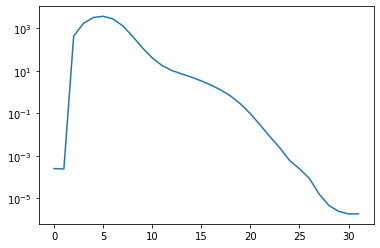

In [30]:
plt.plot(energies)
plt.yscale("log")

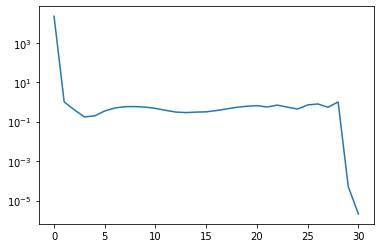

In [31]:
plt.plot(norms)
plt.yscale("log")

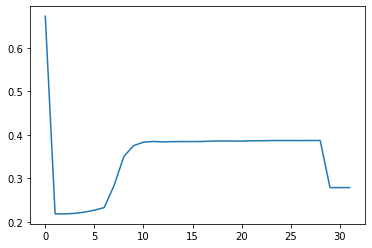

In [32]:
plt.plot(ssims)

## With F2 only

In [110]:
#constants
pn1 = 1e-6

L=1
eta = max(1,pn1*6/gamma)
mu = 2*np.sqrt(1/(1+L*L)/eta)
tau = mu/2
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [99]:
eta

6.000000000000001

In [120]:
def step_test2(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*GradientIm(uk_bar),sigma)
    uk1 = uk-tau*R(vk1)-tau*DivergenceIm(wk1)
    uk_bar1 = uk1+theta*(uk-uk1)

    norm = (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [121]:
#initialisation
n_iter = 0
uk = fourier_op.adj_op(p*y)
image_rec0 = pysap.Image(data=np.abs(uk))

vk = np.copy(uk)
wk = GradientIm(uk)
uk_bar = np.copy(uk)
norm = 2*tol

energies = [energy(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [122]:
while n_iter<100 and norm>tol:
    uk,vk,wk,uk_bar,norm = step_test2(uk,vk,wk,uk_bar)
    n_iter += 1
    norms.append(norm)
    energies.append(f1(uk)+f2(np.array(GradientIm(uk))))
    ssims.append(ssim(uk,u0_mat))
    print(n_iter," iterations:\nCost:",energies[-1],"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

1  iterations:
Cost: 1.4774899299714874e-07 
ssim: 0.6596546973714456 
Norm: 0.856663015063448 

2  iterations:
Cost: 1.6617022360850063e-07 
ssim: 0.6456269688767857 
Norm: 0.1658968743938124 

3  iterations:
Cost: 1.8559098748811943e-07 
ssim: 0.6315100748879788 
Norm: 0.1040275513461795 

4  iterations:
Cost: 2.0591775348661657e-07 
ssim: 0.616856370716581 
Norm: 0.09349839843361998 

5  iterations:
Cost: 2.270860920069044e-07 
ssim: 0.6028877309826356 
Norm: 0.08435698823579958 

6  iterations:
Cost: 2.490414120359033e-07 
ssim: 0.5881731085874011 
Norm: 0.07647568678710281 

7  iterations:
Cost: 2.7173495520533173e-07 
ssim: 0.5750433582018198 
Norm: 0.06990014719473264 

8  iterations:
Cost: 2.951219209902135e-07 
ssim: 0.5605832151819723 
Norm: 0.06434645488544455 

9  iterations:
Cost: 3.191608238664633e-07 
ssim: 0.5472907031747019 
Norm: 0.05960284188613858 

10  iterations:
Cost: 3.4381330087405633e-07 
ssim: 0.5344566896017164 
Norm: 0.05550586960077365 

11  iterations:
Co

KeyboardInterrupt: 

In [123]:
#Final image
image_rec = pysap.Image(data=uk)
print(ssim(uk,u0_mat))
image_rec.show()

0.18288532629911322


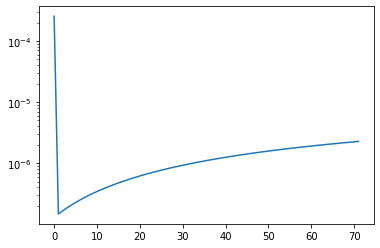

In [124]:
plt.plot(energies)
plt.yscale("log")

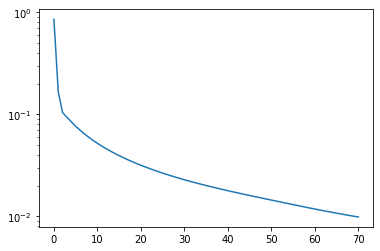

In [125]:
plt.plot(norms)
plt.yscale("log")

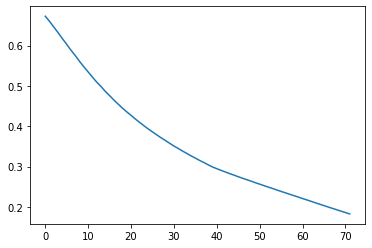

In [126]:
plt.plot(ssims)

# Implementation of the PDHG algorithm

In [293]:
#constants
pn1 = 1e-1
epsilon = 1e-10

L=1
eta = max(np.amax(p)**2,pn1*6/gamma)
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-5

In [171]:
print(g(u0_mat),f1(u0_mat),f2(GradientIm(u0_mat)))

1.9073484054388315e-16 2.962353337276962e-08 0.0005000485137651704


In [294]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*GradientIm(uk_bar),sigma)
    uk1 = prox_G(uk-tau*R(vk1)+tau*DivergenceIm(wk1),tau)
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [295]:
#initialisation
n_iter = 0
uk = fourier_op.adj_op(p*y)
image_rec0 = pysap.Image(data=np.abs(uk))

energies = [energy(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [1]:
vk = np.copy(uk)
wk = GradientIm(uk)
uk_bar = np.copy(uk)
norm = 2*tol
print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energy(uk))

NameError: name 'np' is not defined

In [ ]:
while n_iter<100 and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
    norms.append(norm)
    energies.append(energy(uk))
    ssims.append(ssim(uk,u0_mat))
    print(n_iter," iterations:\nCost:",energies[-1],"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

In [242]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.4699286203416976


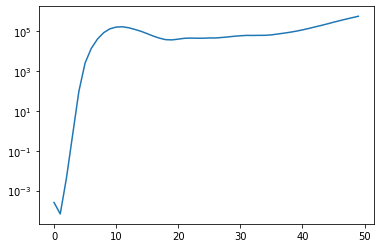

In [141]:
plt.plot(energies)
plt.yscale("log")

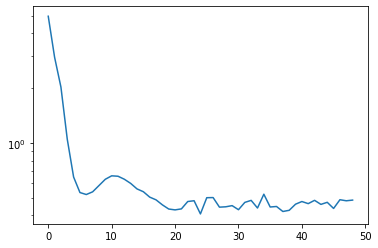

In [142]:
plt.plot(norms)
plt.yscale("log")

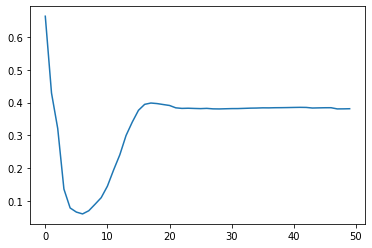

In [143]:
plt.plot(ssims)